<a href="https://colab.research.google.com/github/danielperebinos/Deep-Learning/blob/main/Sigmoid_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/Datasets/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip jp797498e/twitter-entity-sentiment-analysis

  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 85.1MB/s]


In [ ]:
import copy
import re
import unicodedata

import pandas as pd

import torch
torch.manual_seed(57)
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer

import matplotlib.pyplot as plt
import json

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [ ]:
df_train = pd.read_csv('twitter_training.csv')
df_train

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
df_train = pd.read_csv('twitter_training.csv', usecols=[2, 3], names=['sentiment', 'text'])
df_train

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [ ]:
df_train.isna().sum()

sentiment      0
text         686
dtype: int64

In [ ]:
df_train.dropna(inplace = True)
df_train.reset_index(inplace = True)
df_train.drop(columns = ['index'], inplace = True)
df_train.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_test = pd.read_csv('twitter_validation.csv', usecols=[2, 3], names=['sentiment', 'text'])
df_test

,sentiment,text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...
...,...,...
995,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,Positive,Today sucked so it’s time to drink wine n play...
998,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
df_test.isna().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
def unicodeToAscii(string):
  return ''.join(
      char for char in unicodedata.normalize('NFD', string)
      if unicodedata.category(char) != 'Mn'
  )

def normalizeString(string):
  string = unicodeToAscii(string.lower()).strip()
  string = re.sub(r'([.!?])', r' \1', string)
  string = re.sub(r'[^a-zA-Z.!?]+', r' ', string)
  string = re.sub(r'\s+', r' ', string).strip()
  return string

In [ ]:
normalizeString('salut')

'salut'

In [ ]:
PAD_token = 0

class Vocabulary:
  def __init__(self):
    self.PAD_TOKEN = 0
    self.word2index = {}
    self.word2count = {}
    self.index2word = {}
    self.words_count = 1
    self.tokenizer = get_tokenizer('basic_english')
    self.max_length = 0

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.words_count
      self.word2count[word] = 1
      self.index2word[self.words_count] = word
      self.words_count += 1
    else:
      self.word2count[word] += 1
  
  def add_sentence(self, sentence):
    sentence = normalizeString(sentence)
    tokens = self.tokenizer(sentence)

    if len(tokens) > self.max_length:
      self.max_length = len(tokens)
    
    for token in tokens:
      self.add_word(token)
  
  def sentence2indices(self, sentence):
    sentence = normalizeString(sentence)
    result = [self.PAD_TOKEN for _ in range(self.max_length)]
    index = 0
    
    for token in self.tokenizer(sentence):
      if token in self.word2index:
        result[index] = self.word2index[token]
        index += 1
  
    return result

  def toJson(self):
    with open('drive/MyDrive/Data/Vocabulary.json', 'w') as file:
        data = {
            'PAD_TOKEN' : self.PAD_TOKEN,
            'word2index': self.word2index,
            'word2count': self.word2count,
            'index2word': self.index2word,
            'words_count':self.words_count,
            'words_count':self.max_length
        }
        json.dump(data, file)
  
  def fromJson(self):
    with open('drive/MyDrive/Data/Vocabulary.json', 'r') as file:
        data = json.load(file)
        self.PAD_TOKEN = data['PAD_TOKEN']
        self.word2index = data['word2index']
        self.word2count = data['word2count'] 
        self.index2word = data['index2word']
        self.words_count = data['words_count']
        self.max_length = data['words_count']


In [ ]:
vocabulary = Vocabulary()

for text in df_train['text']:
  vocabulary.add_sentence(text)

In [ ]:
vocabulary.toJson()

In [ ]:
vocabulary.words_count

29275

In [ ]:
df_train['text_indices'] = df_train['text'].apply(vocabulary.sentence2indices)
df_test['text_indices'] = df_test['text'].apply(vocabulary.sentence2indices)

In [ ]:
sentiment2label = {'Positive':0, 'Neutral':1, 'Irrelevant':1, 'Negative':2}
df_train['label'] = df_train['sentiment'].apply(lambda x: sentiment2label[x])
df_test['label'] = df_test['sentiment'].apply(lambda x: sentiment2label[x])

In [ ]:
df_train

,sentiment,text,text_indices,label
0,Positive,im getting on borderlands and i will murder yo...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0,...",0
1,Positive,I am coming to the borders and I will kill you...,"[6, 11, 12, 13, 14, 15, 5, 6, 7, 16, 9, 10, 0,...",0
2,Positive,im getting on borderlands and i will kill you ...,"[1, 2, 3, 4, 5, 6, 7, 16, 9, 10, 0, 0, 0, 0, 0...",0
3,Positive,im coming on borderlands and i will murder you...,"[1, 12, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0...",0
4,Positive,im getting on borderlands 2 and i will murder ...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 10, 0, 0, 0, 0...",0
...,...,...,...,...
73991,Positive,Just realized that the Windows partition of my...,"[286, 2807, 64, 14, 4809, 29274, 39, 40, 1867,...",0
73992,Positive,Just realized that my Mac window partition is ...,"[286, 2807, 64, 40, 1867, 6635, 29274, 37, 106...",0
73993,Positive,Just realized the windows partition of my Mac ...,"[286, 2807, 14, 4809, 29274, 39, 40, 1867, 37,...",0
73994,Positive,Just realized between the windows partition of...,"[286, 2807, 557, 14, 4809, 29274, 39, 40, 1867...",0


In [ ]:
class Dataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    return torch.tensor(self.df.loc[index, 'text_indices']), torch.tensor(self.df.loc[index, 'label'])

In [ ]:
train_dataset = Dataset(df_train)
test_dataset = Dataset(df_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = True)

In [ ]:
from torch.nn.modules import dropout
class GRU(nn.Module):
  def __init__(self, hidden_dim, output_dim, n_layers, num_words, drop_prob = 0.2):
    super().__init__()
    self.embedding = nn.Embedding(num_words, hidden_dim)
    self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first = True, dropout = drop_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.embedding(x)
    out, h = self.gru(x)
    out = self.fc(self.ReLU(out[:, -1]))
    return out

In [ ]:
model = GRU(num_words=vocabulary.words_count, hidden_dim=128, output_dim=3, n_layers=2)
model = model.to(device)

In [ ]:
def training_loop(n_epochs, model, optim, loss_fn, train_loader, test_loader):
  train_accuracy = torch.zeros(n_epochs)
  test_accuracy = torch.zeros(n_epochs)

  for epoch in range(n_epochs):
    model.train()
    for examples, labels in train_loader:
      examples = examples.to(device)
      labels = labels.to(device)

      outputs = model(examples)
      loss = loss_fn(outputs, labels)

      optim.zero_grad()
      loss.backward()
      optim.step()


    model.eval()
    for loader, accuracy in [
          (train_loader, train_accuracy),
          (test_loader, test_accuracy)
    ]:

      correct = 0
      total = 0

      with torch.no_grad():
        for examples, labels in loader:
          examples = examples.to(device)
          labels = labels.to(device)

          outputs = model(examples)
          _, predicted = torch.max(outputs, dim=1)

          total += labels.shape[0]
          correct += int((predicted == labels).sum())
      
      accuracy[epoch] = correct/total
  
    best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1]).item()
    if best_test_accuracy:
      best_model = copy.deepcopy(model.state_dict())
  

    print(f'Epoch {epoch + 1}',
          f'Train Accuracy: {train_accuracy[epoch]}',
          f'Test Accuracy: {test_accuracy[epoch]}')

  plt.figure(dpi = 150)
  plt.xlabel('number of Epochs')
  plt.ylabel('Accuracy')
  plt.plot(range(1, n_epochs+1), train_accuracy)
  plt.plot(range(1, n_epochs+1), test_accuracy)
  plt.legend(['Train_accuracy', 'Test_accuracy'])
  plt.grid()
  plt.show()

  return best_model

In [ ]:
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

Epoch 1 Train Accuracy: 0.4187253415584564 Test Accuracy: 0.4569999873638153
Epoch 2 Train Accuracy: 0.5802881121635437 Test Accuracy: 0.6129999756813049
Epoch 3 Train Accuracy: 0.8065300583839417 Test Accuracy: 0.8140000104904175
Epoch 4 Train Accuracy: 0.9001702666282654 Test Accuracy: 0.8930000066757202
Epoch 5 Train Accuracy: 0.9344018697738647 Test Accuracy: 0.9190000295639038
Epoch 6 Train Accuracy: 0.9527406692504883 Test Accuracy: 0.9150000214576721
Epoch 7 Train Accuracy: 0.9559165239334106 Test Accuracy: 0.9309999942779541
Epoch 8 Train Accuracy: 0.9665522575378418 Test Accuracy: 0.9190000295639038
Epoch 9 Train Accuracy: 0.9713903665542603 Test Accuracy: 0.9290000200271606
Epoch 10 Train Accuracy: 0.9739580750465393 Test Accuracy: 0.9229999780654907


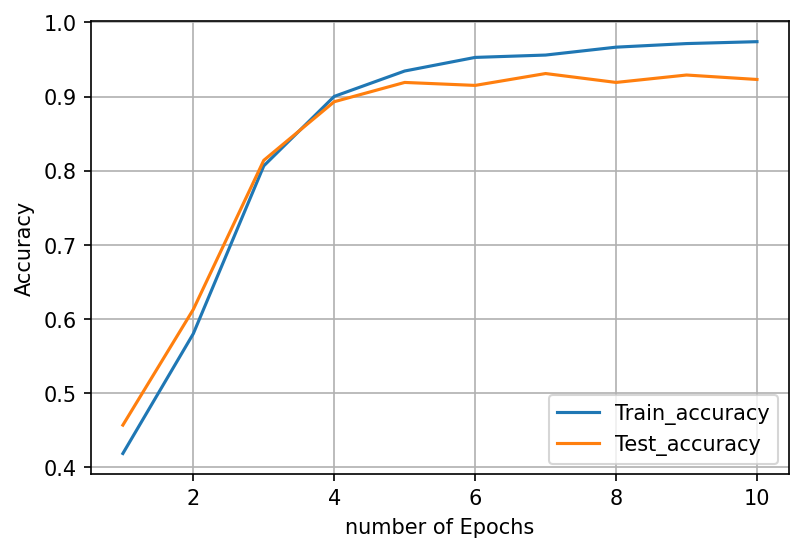

In [ ]:
best_model = training_loop(
    10,
    model,
    optim,
    loss_fn,
    train_loader,
    test_loader
)

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_test = torch.zeros(len(df_test))
y_pred = torch.zeros(len(df_test))
low = 0

model.eval()
with torch.no_grad():
  for examples, labels in test_loader:
    examples = examples.to(device)
    labels = labels.to(device)

    outputs = model(examples)
    _, predicted = torch.max(outputs, dim=1)

    high = low + labels.shape[0]
    y_test[low : high] = labels
    y_pred[low : high] = predicted
    low = high

    total += labels.shape[0]
    correct += int((predicted == labels).sum())

accuracy = correct / total
accuracy

0.931

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Text(0.5, 32.08333333333333, 'Predicted Label')

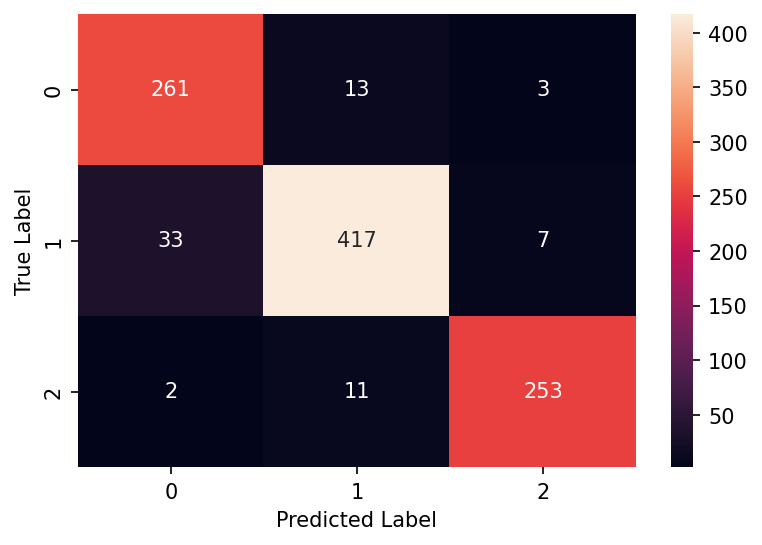

In [ ]:
plt.figure(dpi = 150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Data/SentimentAnalysis_gpu.pth')

In [ ]:
model.to('cpu')

GRU(
  (embedding): Embedding(29275, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (ReLU): ReLU()
)

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/Data/SentimentAnalysis_cpu.pth')

GRU(
  (embedding): Embedding(29275, 128)
  (gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (ReLU): ReLU()
)